In [45]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
from pathlib import Path
import itertools
from functools import reduce

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

plt.style.use(["science", "no-latex", "grid"])

In [47]:
def pl_select(condlist: list[pl.Expr], choicelist: list[pl.Expr]) -> pl.Expr:
    return reduce(
        lambda expr, cond_choice: expr.when(cond_choice[0]).then(cond_choice[1]),
        zip(condlist, choicelist),
        pl.when(condlist[0]).then(choicelist[0]),
    )

In [48]:
files = list(
    Path("/Users/saad.souilmi/dev_python/aqr/data/QR/v1/raw/AAL/xnas-itch").glob(
        "*.parquet"
    )
)

df = pl.read_parquet(list(files)).sort(["date", "ts_event"])
df = df.filter(
    (
        pl.col("event_side")
        .replace({"A": 1, "B": -1})
        .cast(int)
        .mul(pl.col("event_queue_nbr"))
        >= 0
    )
    & pl.col("spread").le(4)
)
df = df.with_columns(pl.col("event").replace({"Trd_All": "Trd"}))
df = df.with_columns(
    pl.when(pl.col("event_queue_nbr").lt(0))
    .then(pl.col("event_queue_nbr").sub(pl.col("best_bid_nbr")).sub(1))
    .otherwise(pl.col("event_queue_nbr").sub(pl.col("best_ask_nbr")).add(1))
    .alias("event_q")
)

In [49]:
condlist = [pl.col("best_bid_nbr").eq(-i) for i in range(1, 11)]
choicelist = [pl.col(f"Q_{-i}") for i in range(1, 11)]
best_bid = pl_select(condlist, choicelist).alias("best_bid").truediv(500).ceil()

condlist = [pl.col("best_ask_nbr").eq(i) for i in range(1, 11)]
choicelist = [pl.col(f"Q_{i}") for i in range(1, 11)]
best_ask = pl_select(condlist, choicelist).alias("best_ask").truediv(500).ceil()
imb = ((best_bid - best_ask) / (best_bid + best_ask)).alias("imb")

df = df.with_columns(imb)

In [50]:
bins = np.arange(11, step=1) / 10
condlist = [
    *[
        pl.col("imb").ge(left) & pl.col("imb").lt(right)
        for left, right in zip(-bins[1:][::-1], -bins[:-1][::-1])
    ],
    pl.col("imb").eq(0),
    *[
        pl.col("imb").gt(left) & pl.col("imb").le(right)
        for left, right in zip(bins[:-1], bins[1:])
    ],
]
choicelist = [*(-bins[1:][::-1]), 0, *bins[1:]]
df = df.with_columns(pl_select(condlist, choicelist).alias("imb_bin"))

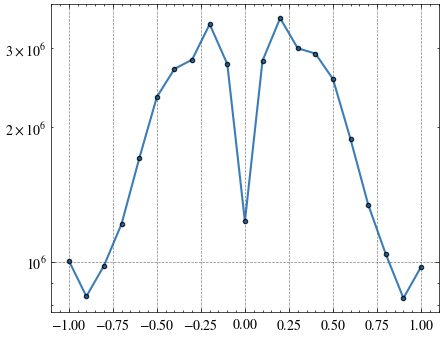

In [7]:
plt.figure(figsize=(5, 4))
stat = df.group_by("imb_bin").len().sort("imb_bin")

plt.plot(stat["imb_bin"], stat["len"], alpha=0.8, ms=3, marker="o", mec="k", lw=1.5)
plt.yscale("log")
plt.show()

In [8]:
def event_probas_spread1(df: pl.DataFrame):
    stat = df.group_by(["imb_bin", "spread", "event", "event_side", "event_q"]).agg(
        pl.len()
    )
    stat = stat.filter(pl.col("spread").eq(1) & pl.col("event_q").is_between(-2, 2))
    stat = stat.with_columns(
        pl.col("len").truediv(pl.col("len").sum().over("imb_bin")).alias("proba")
    ).sort(["event", "event_side", "imb_bin"])
    stat1 = (
        stat.with_columns(
            pl.col("imb_bin")
            .sign()
            .mul(pl.col("event_side").replace({"A": 1, "B": -1}).cast(int))
            .alias("sign"),
            pl.col("imb_bin").abs(),
            pl.col("event_q").abs(),
        )
        .group_by(["imb_bin", "spread", "event", "event_q", "sign"])
        .agg(pl.col("len").sum())
        .with_columns(
            pl.col("sign")
            .cast(str)
            .replace({"1.0": "A", "0.0": "A", "-1.0": "B"})
            .alias("event_side")
        )
    )

    stat2 = stat1.with_columns(
        -pl.col("imb_bin"), pl.col("event_side").replace({"A": "B", "B": "A"})
    )

    stat = pl.concat((stat1, stat2)).with_columns(
        proba=pl.col("len").truediv(pl.col("len").sum().over("imb_bin"))
    )

    stat = stat.with_columns(
        pl.col("event_q").mul(pl.col("event_side").replace({"A": 1, "B": -1}).cast(int))
    )
    stat = stat.sort(["imb_bin", "spread", "event"])

    return stat.drop("sign").select(
        "imb_bin", "spread", "event", "event_q", "len", "event_side", "proba"
    )


def event_probas_spread2(df: pl.DataFrame):
    stat = (
        df.filter(
            pl.col("event").is_in(["Create_Bid", "Create_Ask"]) & pl.col("spread").ge(2)
        )
        .with_columns(spread=2)
        .group_by(["imb_bin", "spread", "event", "event_side"])
        .len()
    )
    stat = stat.filter(
        pl.col("event")
        .replace({"Create_Ask": 1, "Create_Bid": -1})
        .cast(int)
        .mul(pl.col("event_side").replace({"A": 1, "B": -1}).cast(int))
        .gt(0)
    )
    stat1 = (
        stat.with_columns(
            pl.col("event_side")
            .replace({"A": 1, "B": -1})
            .cast(int)
            .mul(pl.col("imb_bin").sign())
            .alias("sign"),
            pl.col("imb_bin").abs(),
        )
        .group_by(["imb_bin", "spread", "sign"])
        .agg(pl.col("len").sum())
        .with_columns(
            pl.col("sign")
            .cast(str)
            .replace(
                {
                    "1.0": "Create_Ask",
                    "-0.0": "Create_Ask",
                    "0.0": "Create_Ask",
                    "-1.0": "Create_Bid",
                }
            )
            .alias("event")
        )
    )
    stat2 = stat1.with_columns(
        -pl.col("imb_bin"),
        pl.col("event").replace(
            {"Create_Ask": "Create_Bid", "Create_Bid": "Create_Ask"}
        ),
    )

    stat = pl.concat([stat1, stat2])
    stat = stat.with_columns(
        pl.col("len").truediv(pl.col("len").sum().over("imb_bin")).alias("proba")
    ).sort("imb_bin")

    return (
        stat.with_columns(
            event_q=pl.lit(0).cast(pl.Int64),
            event_side=pl.col("event").replace({"Create_Bid": "B", "Create_Ask": "A"}),
        )
        .drop("sign")
        .select("imb_bin", "spread", "event", "event_q", "len", "event_side", "proba")
    )

In [9]:
stat = pl.concat([event_probas_spread1(df), event_probas_spread2(df)]).sort(
    "imb_bin", "event", "event_side"
)

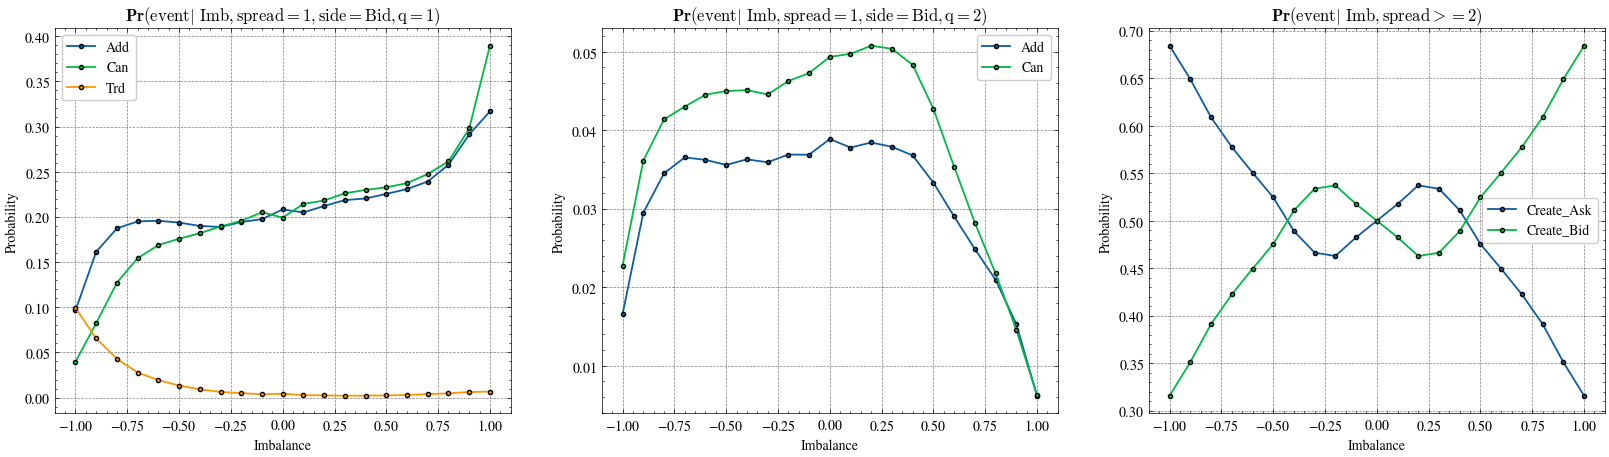

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

for e in ["Add", "Can", "Trd"]:
    data = stat.filter(pl.col("event").eq(e) & pl.col("event_q").eq(-1))
    ax1.plot(data["imb_bin"], data["proba"], label=e, ms=3, mec="k", marker="o", lw=1.3)
for e in ["Add", "Can"]:
    data = stat.filter(pl.col("event").eq(e) & pl.col("event_q").eq(-2))
    ax2.plot(data["imb_bin"], data["proba"], label=e, ms=3, mec="k", marker="o", lw=1.3)
for e in ["Create_Ask", "Create_Bid"]:
    data = stat.filter(pl.col("event").eq(e))
    ax3.plot(data["imb_bin"], data["proba"], label=e, ms=3, mec="k", marker="o", lw=1.3)


ax1.set_ylabel("Probability")
ax2.set_ylabel("Probability")
ax3.set_ylabel("Probability")
ax1.set_xlabel("Imbalance")
ax2.set_xlabel("Imbalance")
ax3.set_xlabel("Imbalance")
ax1.legend()
ax2.legend()
ax3.legend()
ax1.set_title(
    r"$\mathbf{Pr}(\text{event} | \text{ Imb}, \text{spread}=1, \text{side}=\text{Bid}, \text{q}=1)$"
)
ax2.set_title(
    r"$\mathbf{Pr}(\text{event} | \text{ Imb}, \text{spread}=1, \text{side}=\text{Bid}, \text{q}=2)$"
)
ax3.set_title(r"$\mathbf{Pr}(\text{event} | \text{ Imb}, \text{spread}>= 2)$")
plt.show()

In [11]:
# stat.write_csv("../data/AAL2/event_probabilities.csv")

In [52]:
df_ = df.filter(pl.col("event_q").abs().le(2) & pl.col("spread").le(4)).select(
    "date",
    "ts_event",
    "imb_bin",
    pl.when(pl.col("spread").eq(1)).then(1).otherwise(2).alias("spread"),
)
df_ = df_.with_columns(
    pl.col("ts_event").diff().over("date").alias("dt").cast(int)
).filter(pl.col("dt").gt(0))
lamda = df_.group_by("imb_bin", "spread").agg(pl.col("dt").mean())

In [55]:
lamda = (
    lamda.with_columns(pl.col("imb_bin").abs())
    .group_by("imb_bin", "spread")
    .agg(pl.col("dt").mean())
)
lamda = pl.concat(
    (lamda, lamda.filter(pl.col("imb_bin").ne(0)).with_columns(-pl.col("imb_bin")))
).sort("imb_bin")

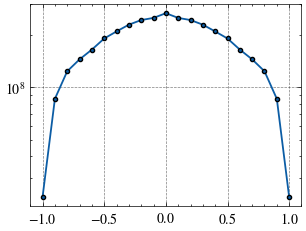

In [25]:
plt.plot(lamda["imb_bin"], lamda["dt"], marker="o", ms=3, mec="k", lw=1.3)
plt.yscale("log")

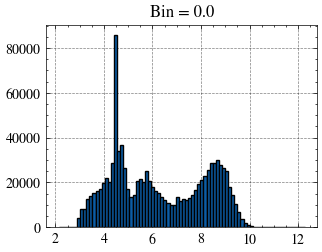

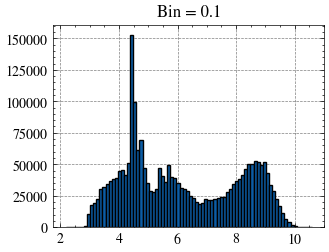

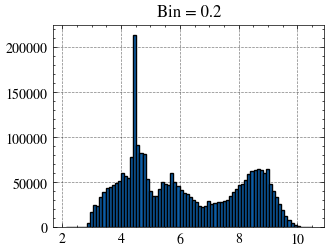

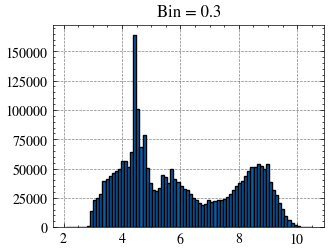

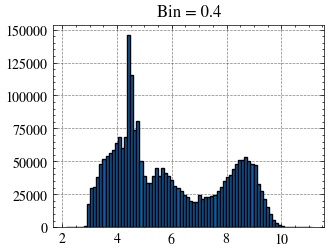

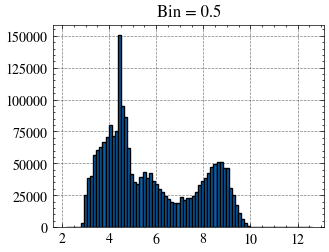

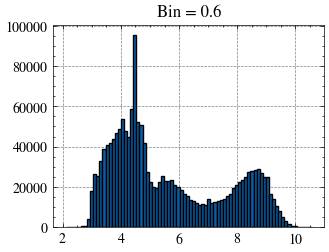

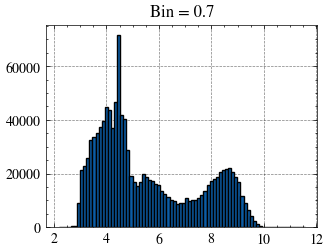

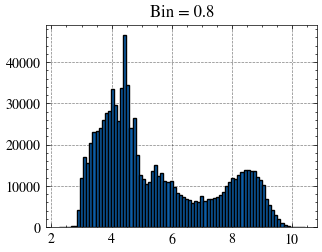

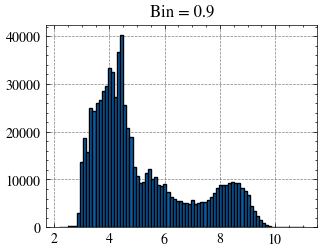

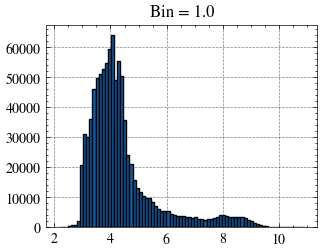

In [22]:
for b in lamda["imb_bin"].abs().unique():
    plt.hist(df_.filter(pl.col("imb_bin").eq(b))["dt"].log10(), bins=80, edgecolor="k")
    plt.title(f"Bin = {b}")
    plt.show()
    plt.close()

In [57]:
# lamda.write_csv("../data/AAL2/intensities.csv")

In [91]:
stat = (
    df.filter(pl.col("spread").eq(1) & pl.col("event_q").abs().le(2))
    .select(
        "imb_bin",
        "event",
        pl.when(pl.col("event_q").abs().eq(1))
        .then(pl.col("event_size").truediv(500).ceil())
        .otherwise(pl.col("event_size").truediv(300).ceil())
        .cast(int)
        .alias("event_size"),
        "event_side",
        "event_q",
    )
    .filter(pl.col("event_size").le(50) & pl.col("event_size").ge(1))
)

# Group by state + size to get counts
stat = stat.group_by(["imb_bin", "event", "event_size", "event_q"]).len()

# Symmetrize: combine (imb>0, bid) with (imb<0, ask)
stat = (
    stat.with_columns(
        pl.col("event_q").sign().mul(pl.col("imb_bin").sign()).alias("sign")
    )
    .group_by(
        pl.col("imb_bin").abs(), "event", "sign", "event_size", pl.col("event_q").abs()
    )
    .agg(pl.col("len").sum())
    .with_columns(
        pl.col("sign")
        .cast(str)
        .replace({"1.0": "A", "0.0": "A", "-1.0": "B"})
        .alias("event_side")
    )
    .drop("sign")
)

# Mirror to negative imbalances
stat = pl.concat(
    (
        stat,
        stat.with_columns(
            -pl.col("imb_bin"), pl.col("event_side").replace({"A": "B", "B": "A"})
        ),
    )
)

# Compute probability: P(size | imb_bin, event, event_q)
stat = stat.with_columns(
    pl.col("len")
    .truediv(pl.col("len").sum().over(["imb_bin", "event", "event_q"]))
    .alias("proba")
).sort(["imb_bin", "event", "event_q", "event_size"])

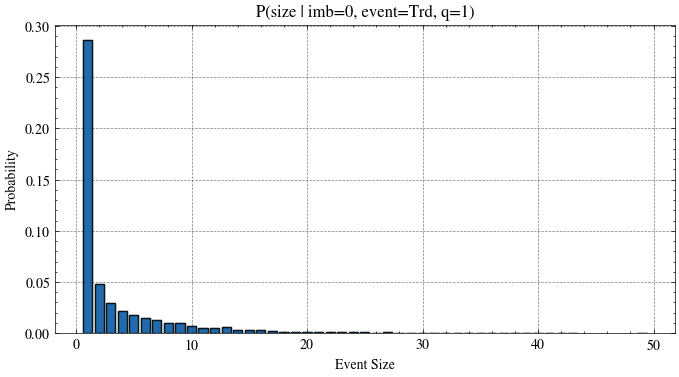

Sum of probas: 1.0000


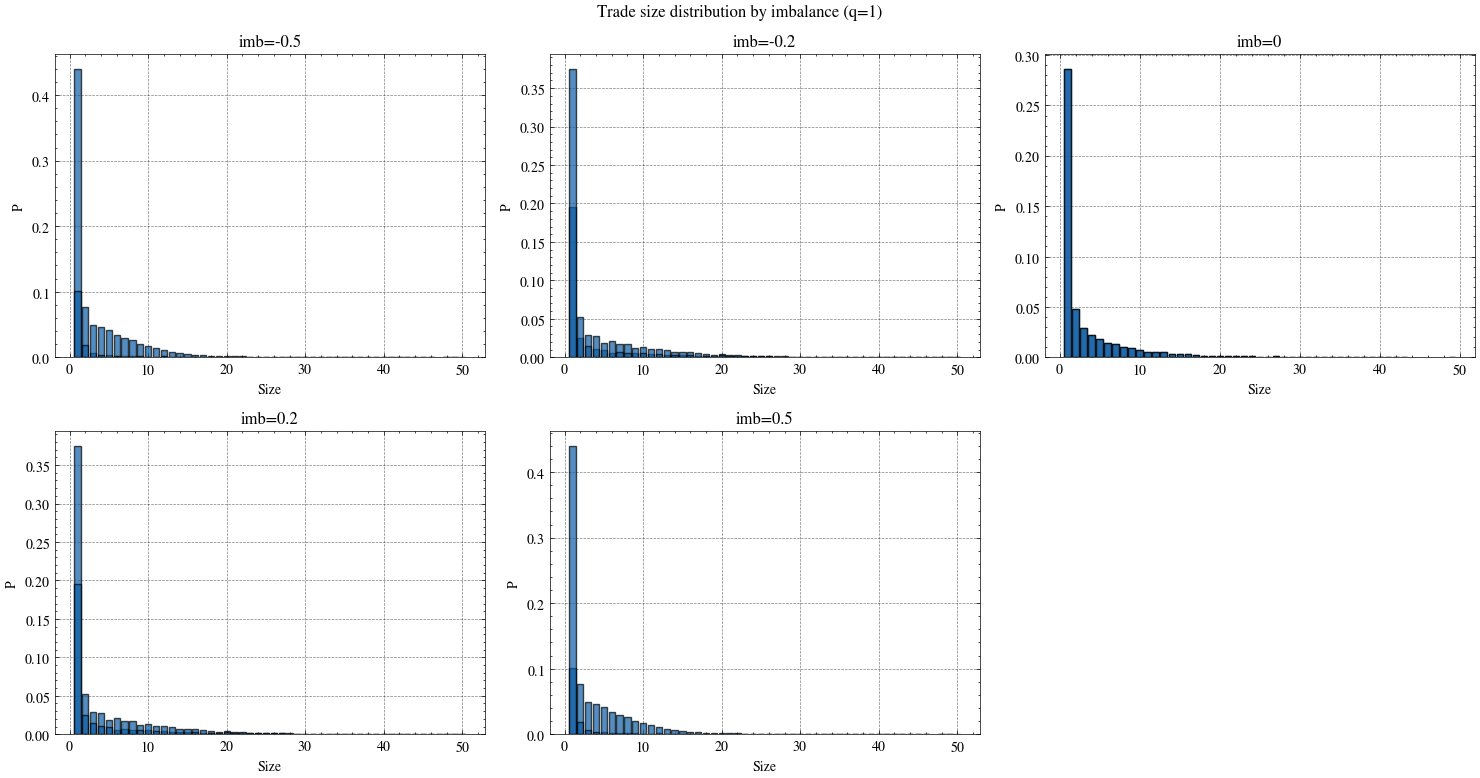

In [99]:
# Pick a state: imb_bin=0, event=Trd, event_q=1
test = stat.filter(
    pl.col("imb_bin").eq(0) & pl.col("event").eq("Trd") & pl.col("event_q").eq(1)
).sort("event_size")

plt.figure(figsize=(8, 4))
plt.bar(test["event_size"], test["proba"], edgecolor="k", alpha=0.7)
plt.xlabel("Event Size")
plt.ylabel("Probability")
plt.title("P(size | imb=0, event=Trd, q=1)")
plt.show()

print(f"Sum of probas: {test['proba'].sum():.4f}")

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, imb in enumerate([-0.5, -0.2, 0, 0.2, 0.5]):
    test = stat.filter(
        pl.col("imb_bin").eq(imb) & pl.col("event").eq("Trd") & pl.col("event_q").eq(1)
    ).sort("event_size")

    axes[i].bar(test["event_size"], test["proba"], edgecolor="k", alpha=0.7)
    axes[i].set_title(f"imb={imb}")
    axes[i].set_xlabel("Size")
    axes[i].set_ylabel("P")

axes[-1].axis("off")
plt.suptitle("Trade size distribution by imbalance (q=1)")
plt.tight_layout()
plt.show()

mean_size = stat.group_by(["imb_bin", "event", "event_q"]).agg(
    (pl.col("event_size") * pl.col("proba")).sum().alias("mean_size")
)

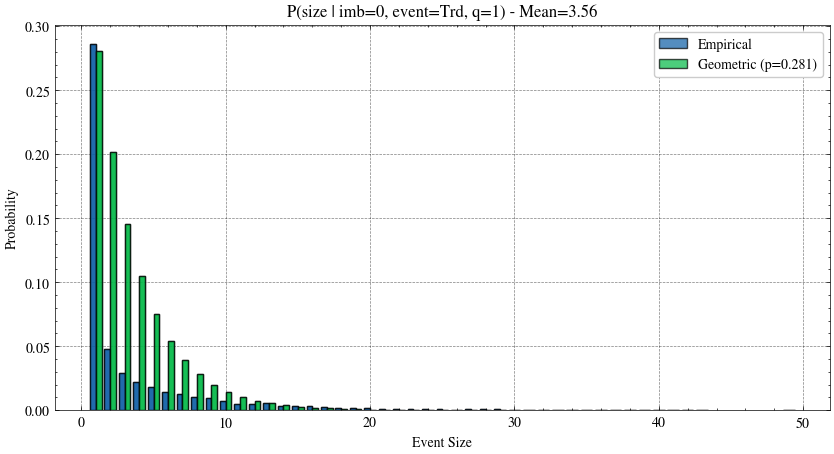

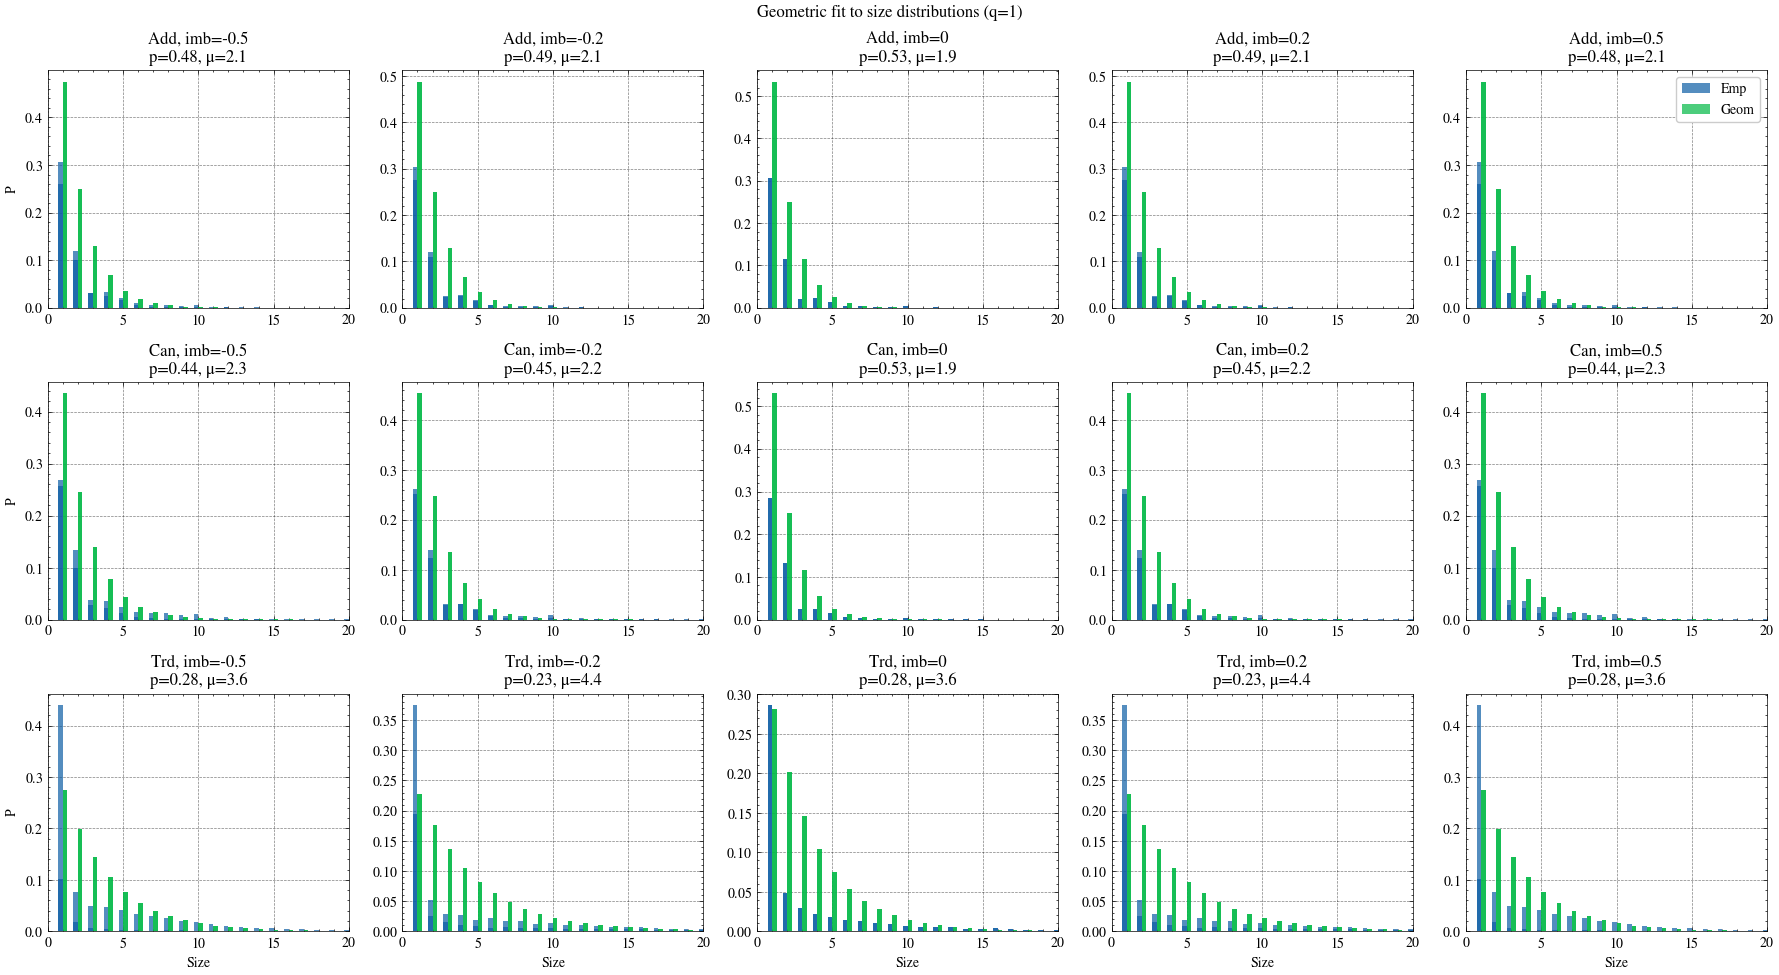

KL divergence (empirical || geometric) by state:
--------------------------------------------------
Add          q= 1: KL=-0.5965 ± 0.0511
Can          q= 1: KL=-0.5494 ± 0.1221
Trd          q= 1: KL=-0.2096 ± 0.0607


In [102]:
from scipy.stats import geom
from scipy.optimize import minimize_scalar


# Fit geometric distribution to a size distribution
def fit_geometric(sizes, probs):
    """Fit geometric distribution by matching mean.
    Geometric with param p has mean 1/p, so p = 1/mean"""
    mean = (sizes * probs).sum()
    p_fit = 1 / mean
    return p_fit, mean


def geometric_pmf(k, p):
    """P(X=k) for geometric starting at k=1"""
    return p * (1 - p) ** (k - 1)


# Test on one state
test = stat.filter(
    pl.col("imb_bin").eq(0) & pl.col("event").eq("Trd") & pl.col("event_q").eq(1)
).sort("event_size")

sizes = test["event_size"].to_numpy()
probs = test["proba"].to_numpy()

p_fit, mean_size = fit_geometric(sizes, probs)
geom_probs = geometric_pmf(sizes, p_fit)

plt.figure(figsize=(10, 5))
plt.bar(sizes - 0.2, probs, width=0.4, label="Empirical", edgecolor="k", alpha=0.7)
plt.bar(
    sizes + 0.2,
    geom_probs,
    width=0.4,
    label=f"Geometric (p={p_fit:.3f})",
    edgecolor="k",
    alpha=0.7,
)
plt.xlabel("Event Size")
plt.ylabel("Probability")
plt.title(f"P(size | imb=0, event=Trd, q=1) - Mean={mean_size:.2f}")
plt.legend()
plt.show()

# Compare across imbalances and events
fig, axes = plt.subplots(3, 5, figsize=(18, 10))
imbs = [-0.5, -0.2, 0, 0.2, 0.5]
events = ["Add", "Can", "Trd"]

for row, event in enumerate(events):
    for col, imb in enumerate(imbs):
        ax = axes[row, col]
        test = stat.filter(
            pl.col("imb_bin").eq(imb)
            & pl.col("event").eq(event)
            & pl.col("event_q").eq(1)
        ).sort("event_size")

        if test.height == 0:
            ax.set_title(f"{event}, imb={imb}\nNo data")
            continue

        sizes = test["event_size"].to_numpy()
        probs = test["proba"].to_numpy()
        p_fit, mean = fit_geometric(sizes, probs)
        geom_probs = geometric_pmf(sizes, p_fit)

        ax.bar(sizes - 0.15, probs, width=0.3, label="Emp", alpha=0.7)
        ax.bar(sizes + 0.15, geom_probs, width=0.3, label="Geom", alpha=0.7)
        ax.set_title(f"{event}, imb={imb}\np={p_fit:.2f}, μ={mean:.1f}")
        ax.set_xlim(0, 20)

        if row == 2:
            ax.set_xlabel("Size")
        if col == 0:
            ax.set_ylabel("P")

axes[0, -1].legend()
plt.suptitle("Geometric fit to size distributions (q=1)")
plt.tight_layout()
plt.show()


# Quantify fit quality with KL divergence
def kl_divergence(p, q):
    """KL(p || q) - lower is better"""
    mask = (p > 0) & (q > 0)
    return (p[mask] * np.log(p[mask] / q[mask])).sum()


print("KL divergence (empirical || geometric) by state:")
print("-" * 50)
for event in ["Add", "Can", "Trd"]:
    for q in [1, -1]:
        kls = []
        for imb in np.arange(-1, 1.1, 0.1):
            imb = round(imb, 1)
            test = stat.filter(
                pl.col("imb_bin").eq(imb)
                & pl.col("event").eq(event)
                & pl.col("event_q").eq(q)
            ).sort("event_size")

            if test.height < 2:
                continue

            sizes = test["event_size"].to_numpy()
            probs = test["proba"].to_numpy()
            p_fit, _ = fit_geometric(sizes, probs)
            geom_probs = geometric_pmf(sizes, p_fit)
            kls.append(kl_divergence(probs, geom_probs))

        if kls:
            print(f"{event:12} q={q:2}: KL={np.mean(kls):.4f} ± {np.std(kls):.4f}")

In [105]:
def fit_geometric(sizes, probs):
    mean = (sizes * probs).sum()
    p_fit = 1 / mean
    return p_fit


# Build the p parameter for each state
results = []
for (imb_bin, event, event_q), group in stat.group_by(["imb_bin", "event", "event_q"]):
    group = group.sort("event_size")
    sizes = group["event_size"].to_numpy()
    probs = group["proba"].to_numpy()

    if len(sizes) > 0 and probs.sum() > 0:
        p = fit_geometric(sizes, probs)
        results.append({"imb_bin": imb_bin, "event": event, "event_q": event_q, "p": p})

size_params = pl.DataFrame(results).sort(["imb_bin", "event", "event_q"])
size_params.write_csv("../data/AAL2/size_distrib.csv")

In [72]:
v = (
    df.filter(pl.col("event").eq("Trd"))
    .select(
        "date",
        pl.col("ts_event").dt.hour().alias("hour"),
        pl.col("event_size").truediv(500).ceil().cast(int),
    )
    .group_by("date", "hour")
    .agg(pl.col("event_size").sum())
    .filter(pl.col("hour").lt(15))
)

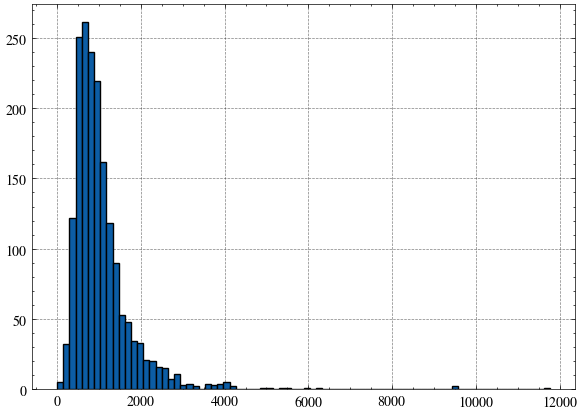

In [73]:
plt.figure(figsize=(7, 5))
plt.hist(v["event_size"], bins=80, edgecolor="k");

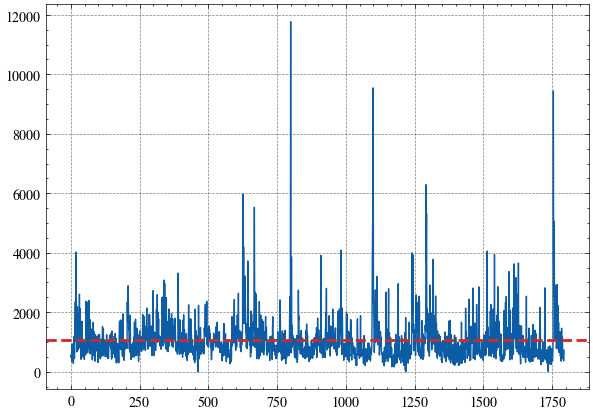

In [81]:
plt.figure(figsize=(7, 5))
plt.plot(v.sort("date")["event_size"])
plt.axhline(v["event_size"].mean(), linestyle="--", lw=2, color="tab:red")
plt.show()

In [86]:
# Load simulation results and compute event probabilities
sim_df = pl.read_parquet("../result.parquet")

# Preprocess simulation data
sim_df = sim_df.with_columns(
    (pl.col("best_ask_price") - pl.col("best_bid_price")).alias("spread"),
    (
        (pl.col("best_bid_vol") - pl.col("best_ask_vol"))
        / (pl.col("best_bid_vol") + pl.col("best_ask_vol"))
    ).alias("imb"),
)

# Bin imbalance (same bins as real data)
bins = np.arange(11, step=1) / 10
condlist = [
    *[
        pl.col("imb").ge(left) & pl.col("imb").lt(right)
        for left, right in zip(-bins[1:][::-1], -bins[:-1][::-1])
    ],
    pl.col("imb").eq(0),
    *[
        pl.col("imb").gt(left) & pl.col("imb").le(right)
        for left, right in zip(bins[:-1], bins[1:])
    ],
]
choicelist = [*(-bins[1:][::-1]), 0, *bins[1:]]
sim_df = sim_df.with_columns(pl_select(condlist, choicelist).alias("imb_bin"))

# Compute event_q and labels
sim_df = sim_df.with_columns(
    pl.when(pl.col("side") == 1)
    .then(pl.col("price") - pl.col("best_ask_price") + 1)
    .otherwise(pl.col("best_bid_price") - pl.col("price") + 1)
    .alias("event_q"),
    pl.col("type")
    .replace({"Trade": "Trd", "CreateAsk": "Create_Ask", "CreateBid": "Create_Bid"})
    .alias("event"),
    pl.when(pl.col("side") == 1)
    .then(pl.lit("A"))
    .otherwise(pl.lit("B"))
    .alias("event_side"),
)

In [87]:
# Compute event probabilities for simulation (spread=1)
def event_probas_spread1_sim(df: pl.DataFrame):
    stat = df.group_by(["imb_bin", "spread", "event", "event_side", "event_q"]).agg(
        pl.len()
    )
    stat = stat.filter(pl.col("spread").eq(1) & pl.col("event_q").is_between(-2, 2))
    stat = stat.with_columns(
        pl.col("len").truediv(pl.col("len").sum().over("imb_bin")).alias("proba")
    ).sort(["event", "event_side", "imb_bin"])

    stat1 = (
        stat.with_columns(
            pl.col("imb_bin")
            .sign()
            .mul(pl.col("event_side").replace({"A": 1, "B": -1}).cast(int))
            .alias("sign"),
            pl.col("imb_bin").abs(),
            pl.col("event_q").abs(),
        )
        .group_by(["imb_bin", "spread", "event", "event_q", "sign"])
        .agg(pl.col("len").sum())
        .with_columns(
            pl.col("sign")
            .cast(str)
            .replace({"1.0": "A", "0.0": "A", "-1.0": "B"})
            .alias("event_side")
        )
    )

    stat2 = stat1.with_columns(
        -pl.col("imb_bin"), pl.col("event_side").replace({"A": "B", "B": "A"})
    )

    stat = pl.concat((stat1, stat2)).with_columns(
        proba=pl.col("len").truediv(pl.col("len").sum().over("imb_bin"))
    )

    stat = stat.with_columns(
        pl.col("event_q").mul(pl.col("event_side").replace({"A": 1, "B": -1}).cast(int))
    )
    stat = stat.sort(["imb_bin", "spread", "event"])

    return stat.drop("sign").select(
        "imb_bin", "spread", "event", "event_q", "len", "event_side", "proba"
    )


def event_probas_spread2_sim(df: pl.DataFrame):
    stat = (
        df.filter(
            pl.col("event").is_in(["Create_Bid", "Create_Ask"]) & pl.col("spread").ge(2)
        )
        .with_columns(spread=2)
        .group_by(["imb_bin", "spread", "event", "event_side"])
        .len()
    )
    stat = stat.filter(
        pl.col("event")
        .replace({"Create_Ask": 1, "Create_Bid": -1})
        .cast(int)
        .mul(pl.col("event_side").replace({"A": 1, "B": -1}).cast(int))
        .gt(0)
    )
    stat1 = (
        stat.with_columns(
            pl.col("event_side")
            .replace({"A": 1, "B": -1})
            .cast(int)
            .mul(pl.col("imb_bin").sign())
            .alias("sign"),
            pl.col("imb_bin").abs(),
        )
        .group_by(["imb_bin", "spread", "sign"])
        .agg(pl.col("len").sum())
        .with_columns(
            pl.col("sign")
            .cast(str)
            .replace(
                {
                    "1.0": "Create_Ask",
                    "-0.0": "Create_Ask",
                    "0.0": "Create_Ask",
                    "-1.0": "Create_Bid",
                }
            )
            .alias("event")
        )
    )
    stat2 = stat1.with_columns(
        -pl.col("imb_bin"),
        pl.col("event").replace(
            {"Create_Ask": "Create_Bid", "Create_Bid": "Create_Ask"}
        ),
    )

    stat = pl.concat([stat1, stat2])
    stat = stat.with_columns(
        pl.col("len").truediv(pl.col("len").sum().over("imb_bin")).alias("proba")
    ).sort("imb_bin")

    return (
        stat.with_columns(
            event_q=pl.lit(0).cast(pl.Int64),
            event_side=pl.col("event").replace({"Create_Bid": "B", "Create_Ask": "A"}),
        )
        .drop("sign")
        .select("imb_bin", "spread", "event", "event_q", "len", "event_side", "proba")
    )


stat_sim = pl.concat(
    [event_probas_spread1_sim(sim_df), event_probas_spread2_sim(sim_df)]
).sort("imb_bin", "event", "event_side")

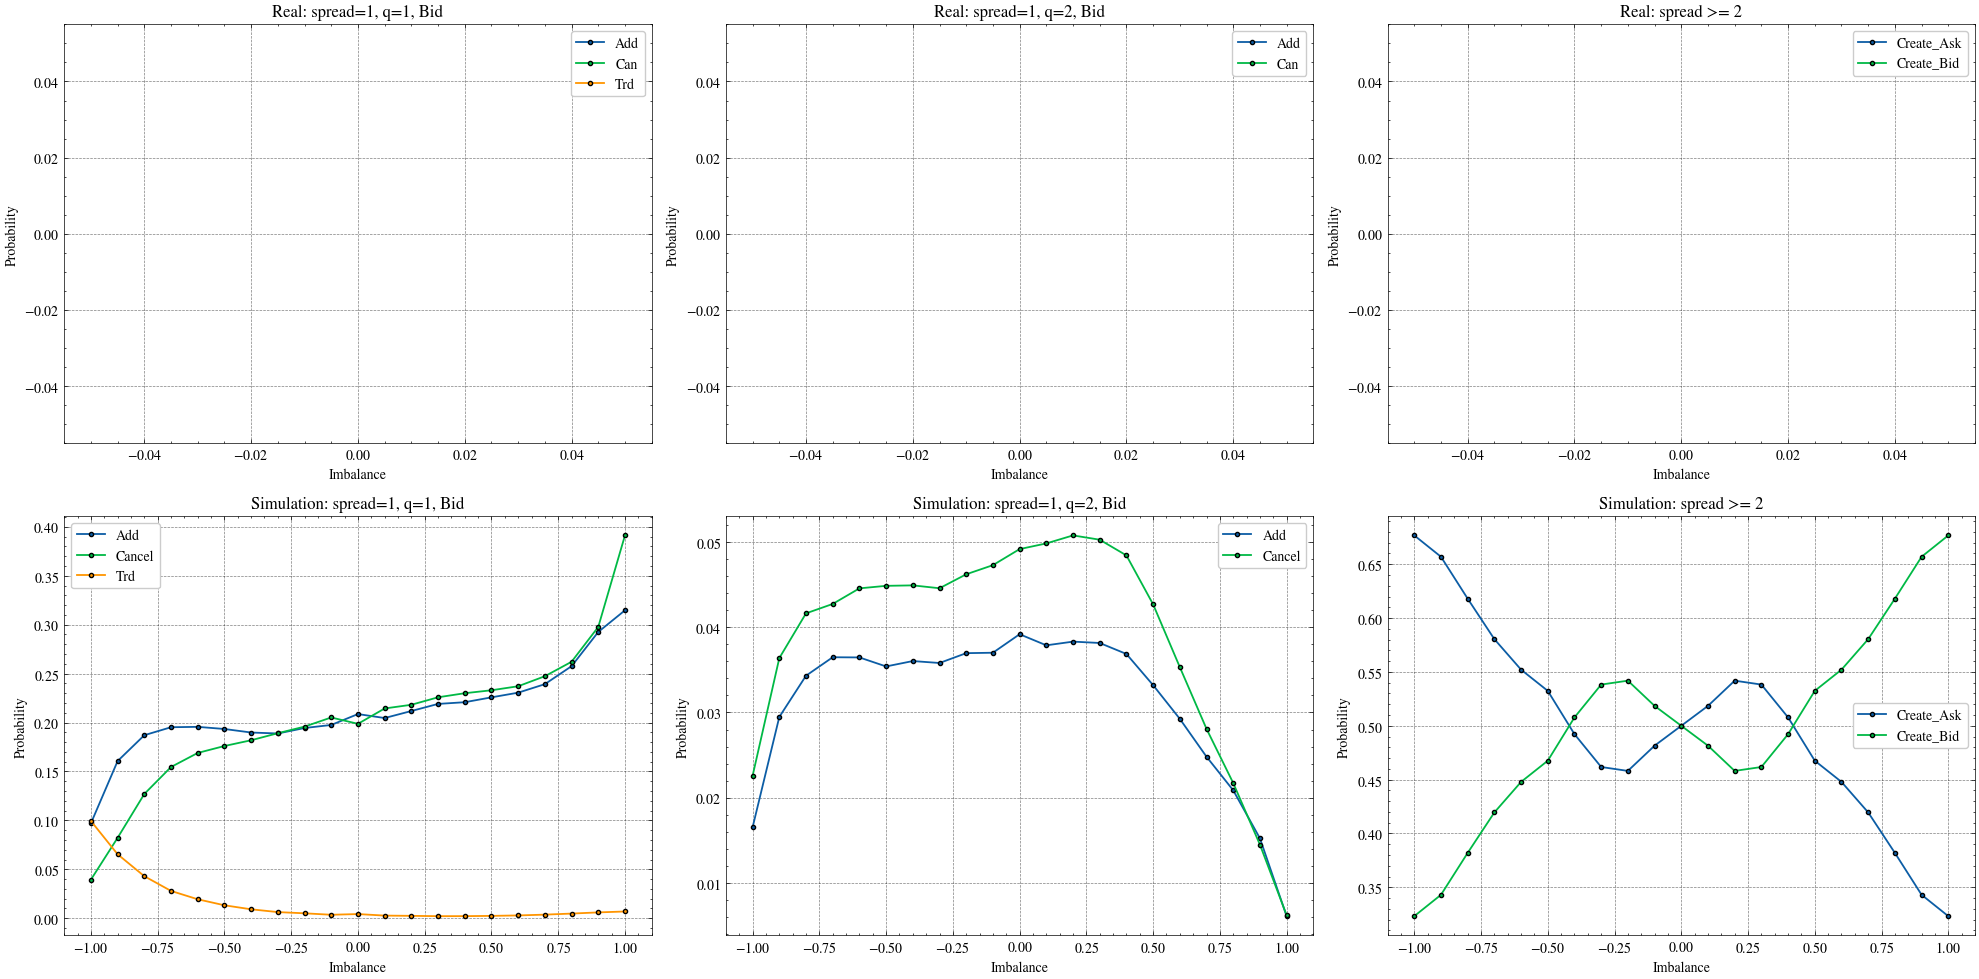

In [88]:
# Compare real vs simulation event probabilities
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# Row 1: Real data
ax1, ax2, ax3 = axes[0]
for e in ["Add", "Can", "Trd"]:
    data = stat.filter(pl.col("event").eq(e) & pl.col("event_q").eq(-1))
    ax1.plot(data["imb_bin"], data["proba"], label=e, ms=3, mec="k", marker="o", lw=1.3)
for e in ["Add", "Can"]:
    data = stat.filter(pl.col("event").eq(e) & pl.col("event_q").eq(-2))
    ax2.plot(data["imb_bin"], data["proba"], label=e, ms=3, mec="k", marker="o", lw=1.3)
for e in ["Create_Ask", "Create_Bid"]:
    data = stat.filter(pl.col("event").eq(e))
    ax3.plot(data["imb_bin"], data["proba"], label=e, ms=3, mec="k", marker="o", lw=1.3)

ax1.set_ylabel("Probability")
ax1.set_xlabel("Imbalance")
ax1.legend()
ax1.set_title("Real: spread=1, q=1, Bid")

ax2.set_ylabel("Probability")
ax2.set_xlabel("Imbalance")
ax2.legend()
ax2.set_title("Real: spread=1, q=2, Bid")

ax3.set_ylabel("Probability")
ax3.set_xlabel("Imbalance")
ax3.legend()
ax3.set_title("Real: spread >= 2")

# Row 2: Simulation
ax4, ax5, ax6 = axes[1]
for e in ["Add", "Cancel", "Trd"]:
    data = stat_sim.filter(pl.col("event").eq(e) & pl.col("event_q").eq(-1))
    ax4.plot(data["imb_bin"], data["proba"], label=e, ms=3, mec="k", marker="o", lw=1.3)
for e in ["Add", "Cancel"]:
    data = stat_sim.filter(pl.col("event").eq(e) & pl.col("event_q").eq(-2))
    ax5.plot(data["imb_bin"], data["proba"], label=e, ms=3, mec="k", marker="o", lw=1.3)
for e in ["Create_Ask", "Create_Bid"]:
    data = stat_sim.filter(pl.col("event").eq(e))
    ax6.plot(data["imb_bin"], data["proba"], label=e, ms=3, mec="k", marker="o", lw=1.3)

ax4.set_ylabel("Probability")
ax4.set_xlabel("Imbalance")
ax4.legend()
ax4.set_title("Simulation: spread=1, q=1, Bid")

ax5.set_ylabel("Probability")
ax5.set_xlabel("Imbalance")
ax5.legend()
ax5.set_title("Simulation: spread=1, q=2, Bid")

ax6.set_ylabel("Probability")
ax6.set_xlabel("Imbalance")
ax6.legend()
ax6.set_title("Simulation: spread >= 2")

plt.tight_layout()
plt.show()